# Python tutorial

Apart from the CLI, NerfBaselines also provides a Python API that allows you to interact with the methods programmatically. This tutorial will guide you through the process of using the Python API to train a method, evaluate it, and visualize the results.

```{button-link} https://colab.research.google.com/github/nerfbaselines/nerfbaselines/blob/main/docs/python-tutorial.ipynb
:color: primary
:outline:
:align: left
Open in Colab
```


In [1]:
# Setup script for the colab environment
if 'google.colab' in str(get_ipython()):
    # Install nerfbaselines and conda to google colab
    !pip install -q condacolab git+https://github.com/nerfbaselines/nerfbaselines.git
    import condacolab
    condacolab.install()
    # Pre-install gaussian-splatting method to have clear output on subsequence steps
    !nerfbaselines install --method gaussian-splatting

## Rendering images
In this section, we will demonstrate how to render custom images using the Python API. We assume you already have a checkpoint of your model obtained either by downloading the checkpoint from [nerfbaselines.github.io](https://nerfbaselines.github.io), by running the `nerfbaselines train` command, or by training the method using the Python API shown at the end of this tutorial.

First of all, you need to start the backend and load the checkpoint. There is a utility function {py:func}`nerfbaselines.load_checkpoint` that simplifies this process.

In [2]:
# We use the ExitStack to manage the context managers such that
# we can persist the contexts between cells. This is rarely needed
# in practice, but it is useful for this tutorial.
from contextlib import ExitStack
stack = ExitStack().__enter__()

import pprint
from nerfbaselines import load_checkpoint

# We will load the official gaussian-splatting checkpoint 
# for mipnerf360/bicycle scene. Note, the checkpoint_path 
# can be a local path or a URL, and it can be a path within 
# a zip file. In that case, NerfBaselines will automatically 
# download/extract the file to a temporary directory to 
# load the checkpoint.
checkpoint_path = "https://huggingface.co/nerfbaselines/nerfbaselines/resolve/main/gaussian-splatting/mipnerf360/garden.zip/checkpoint"

# Start the conda backend and load the checkpoint
model, _ = stack.enter_context(load_checkpoint(checkpoint_path, backend="conda"))

# Print model information
pprint.pprint(model.get_info())

Downloading: 100%|██████████| 5.85G/5.85G [02:54<00:00, 33.4MiB/s]
info: Connection accepted, protocol: shm-pickle5-buffers
{'hparams': {'compute_cov3D_python': False,
             'convert_SHs_python': False,
             'debug': False,
             'densification_interval': 100,
             'densify_from_iter': 500,
             'densify_grad_threshold': 0.0002,
             'densify_until_iter': 15000,
             'feature_lr': 0.0025,
             'iterations': 30000,
             'lambda_dssim': 0.2,
             'opacity_lr': 0.05,
             'opacity_reset_interval': 3000,
             'percent_dense': 0.01,
             'position_lr_delay_mult': 0.01,
             'position_lr_final': 1.6e-06,
             'position_lr_init': 0.00016,
             'position_lr_max_steps': 30000,
             'random_background': False,
             'rotation_lr': 0.001,
             'scale_coords': None,
             'scaling_lr': 0.005,
             'sh_degree': 3,
             'white_bac

After loading the checkpoint, you can interact with the model to render custom images.
Rendering is done by calling the `render` method of the model. The `render` method takes 
the following arguments:
- `camera`: A single {py:class}`nerfbaselines.Cameras` object which can be created by using {py:func}`nerfbaselines.new_cameras`.
- `options`: A dictionary with rendering options. Some of the commonly supported options are:
   - `embedding`: Apperance embedding for the viewpoint (if supported).
   - `outputs`: A tuple of outputs to render. Commonly supported outputs are `rgb`, `depth`, `accumulation`, `normal`, however, each method can support different outputs. You should call `model.get_info()["supported_outputs"]` to get the list of supported outputs. Note, that this arguments only gives a hint to the method to render the specified outputs, but the method can decide to render additional outputs or ignore unsupported outputs.
   - `output_type_dtypes`: A dictionary with output types and dtypes. This is usually used to speed up the rendering process by specifying `{'color': 'uint8'}` which will convert image to `uint8` before transmitting it through the communication channel.

The following code snippet demonstrates how to render an image using the loaded model:

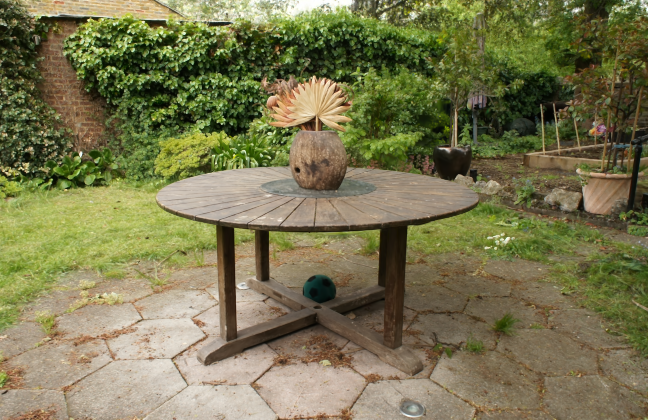

In [4]:
from nerfbaselines import new_cameras, camera_model_to_int
import numpy as np
from PIL import Image

# Camera parameters 
# pose: a 3x4 matrix representing the camera pose as camera-to-world transformation
pose = np.array([
    [ 0.981, -0.026,  0.194, -0.463],
    [ 0.08,   0.958, -0.275,  2.936],
    [-0.179,  0.286,  0.941, -3.12 ]], dtype=np.float32)

# Camera intrinsics
fx, fy, cx, cy = 481, 481, 324, 210
# Image resolution
w, h =  648, 420

# Create camera object
camera = new_cameras(
    poses=pose,
    intrinsics=np.array([fx, fy, cx, cy], dtype=np.float32),
    image_sizes=np.array([w, h], dtype=np.int32),
    camera_models=np.array(camera_model_to_int("pinhole"), dtype=np.int32),
)

# Render the image
outputs = model.render(camera=camera, options={"output_type_dtypes": {"color": "uint8"}})

# Display the rendered image
display(Image.fromarray(outputs["color"]))

In [5]:
# In this tutorial, we used `ExitStack` to simplify context management. 
# We need to close the context to release the memory.
stack.close() 

info: Backend worker finished


Loading trained model at iteration 30000 [22/09 22:12:15]
Loading Training Cameras [22/09 22:12:15]
Loading Test Cameras [22/09 22:12:15]


## Training a method
To train a method using the Python API, you can either write your own training loop, or use the provided {py:class}`nerfbaselines.training.Trainer` class. 
First we show how training can be done with a custom training loop:

In [8]:
from tqdm import tqdm
from contextlib import ExitStack
from nerfbaselines import backends
from nerfbaselines.datasets import load_dataset
from nerfbaselines import (
    build_method_class,
    get_method_spec,
)
from nerfbaselines.training import (
    get_presets_and_config_overrides,
)

# We will use the "gaussian-splatting" method and "conda" backend
method_name = "gaussian-splatting"
backend = "conda"

# We will write the output to directory "output"
output_path = "output"

# We will use the data from the "mipnerf360/bicycle" scene
data = "external://mipnerf360/bicycle"

# We use the exit stack to simplify the context management
stack = ExitStack().__enter__()

# Prepare the output directory, and mount it if necessary (e.g., for docker backend)
stack.enter_context(backends.mount(output_path, output_path))

# Get the method specification for a registered method
method_spec = get_method_spec(method_name)

# Build the method class and start the backend
method_cls = stack.enter_context(build_method_class(method_spec, backend))

# Load train dataset
# We use the method info to load the required features and supported camera models
method_info = method_cls.get_method_info()
train_dataset = load_dataset(data, 
                             split="train", 
                             features=method_info.get("required_features"),
                             supported_camera_models=method_info.get("supported_camera_models"),
                             load_features=True)
# Load eval dataset
test_dataset = load_dataset(data, 
                            split="test", 
                            features=method_info.get("required_features"),
                            supported_camera_models=method_info.get("supported_camera_models"),
                            load_features=True)

# Each method can specify custom presets and config overrides
# Apply config overrides for the train dataset
presets, config_overrides = get_presets_and_config_overrides(
    method_spec, train_dataset["metadata"])

# Build the method
model = method_cls(
    train_dataset=train_dataset,
    config_overrides=config_overrides,
)

# Training loop
model_info = model.get_info()

# In this example we override the total number of iterations
# to make the training faster
model_info["num_iterations"] = 100

with tqdm(total=model_info["num_iterations"]) as pbar:
    for step in range(model_info["num_iterations"]):
        metrics = model.train_iteration(step)
        pbar.set_postfix({"psnr": f"{metrics['psnr']:.2f}"})
        pbar.update()

# Save the model
model.save("checkpoint")
# Create a minimal nb-info.json file such that the model can be loaded
with open("nb-info.json", "w") as f:
    f.write(f'{{"method": "{method_name}"}}')

# Close the stack. In real code, you should use the context manager
stack.close()

info: Connection accepted, protocol: shm-pickle5-buffers
loading images: 100%|██████████| 169/169 [00:01<00:00, 95.06it/s]
/scratch/project/open-28-73/jonas/repos/nerfbaselines/nerfbaselines/datasets/_common.py:312: UserWarning: Downscaled image sizes are not a multiple of camera sizes.
  warnings.warn("Downscaled image sizes are not a multiple of camera sizes.")
loading images: 100%|██████████| 25/25 [00:00<00:00, 94.32it/s]
Loading Training Cameras [22/09 22:13:43]
Loading Test Cameras [22/09 22:13:51]
Number of points at initialisation :  54275 [22/09 22:13:51]
100%|██████████| 100/100 [00:08<00:00, 11.27it/s, psnr=6.56]
info: Backend worker finished


## Using Trainer class

The {py:class}`Trainer` class provides a high-level interface for training a method, and it takes care of loading the dataset, creating the model, and saving the checkpoints. The following code snippet extends the previous example and optimizes the model using the {py:class}`Trainer` class.

In [10]:
from contextlib import ExitStack
from nerfbaselines import backends
from nerfbaselines import (
    build_method_class,
)
from nerfbaselines.training import (
    Trainer, 
    Indices, 
    build_logger,
)

# We use the exit stack to simplify the context management
stack = ExitStack().__enter__()

# Prepare the output directory, and mount it if necessary (e.g., for docker backend)
stack.enter_context(backends.mount(output_path, output_path))

# Build the method class and start the backend
method_cls = stack.enter_context(build_method_class(method_spec, backend))

# Build the method
model = method_cls(
    train_dataset=train_dataset,
    config_overrides=config_overrides,
)

# Build the trainer
trainer = Trainer(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    method=model,
    output=output_path,
    save_iters=Indices.every_iters(10_000, zero=True),  # Save the model every 10k iterations
    eval_few_iters=Indices.every_iters(2_000),  # Eval on few images every 2k iterations
    eval_all_iters=Indices([-1]),  # Eval on all images at the end
    logger=build_logger(("tensorboard",)),  # We will log to tensorboard
    generate_output_artifact=True,
    config_overrides=config_overrides,
    applied_presets=frozenset(presets),
)

# In this example we override the total number of iterations
# to make the training faster
trainer.num_iterations = 100

# Finally, we train the method
trainer.train()

# Close the stack. In real code, you should use the context manager
stack.close()

info: Connection accepted, protocol: shm-pickle5-buffers
Loading Training Cameras [22/09 22:15:11]
Loading Test Cameras [22/09 22:15:18]
Number of points at initialisation :  54275 [22/09 22:15:18]
training: 100%|██████████| 100/100 [00:31<00:00, 11.91it/s, train/psnr=14.4304]{'applied_presets': [],
 'checkpoint_sha256': 'acf027e845ff29e9db9558bd0a1166c87d5a77ca07ddb46f609c68661cb228cc',
 'config_overrides': {},
 'dataset_metadata': {'color_space': 'srgb',
                      'downscale_factor': 4,
                      'evaluation_protocol': 'nerf',
                      'expected_scene_scale': 4.299345,
                      'id': 'mipnerf360',
                      'scene': 'bicycle',
                      'type': 'object-centric',
                      'viewer_initial_pose': array([[-0.948501,  0.055669,  0.311843, -0.329421],
       [-0.316162, -0.227448, -0.921037,  0.961329],
       [ 0.019655, -0.972198,  0.233335, -0.144017]], dtype=float32),
                      'viewer_tr